## Spotify Musical Feature Analysis by Decade

In [1]:
## This notebook going off of what was done in the Google Colab file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zgg6uuqr because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Data importing & formatting

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/aclink88/musicFeatureAnalysis/main/data/data.csv")
data['decade'] = (data.year//10)*10
#data.drop(columns = ['artists', 'name', 'release_date']).to_csv('withDecade.csv', index=False,  header=True)

### EDA

In [3]:
display(data['decade'].unique())

array([1920, 1930, 1940, 1950, 1960, 2000, 2010, 2020, 1990, 1970, 1980])

In [4]:
avgs = data.groupby('decade').mean()
display(avgs.head(11))

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
decade,,,,,,,,,,,,,,,
1920,0.792778,0.585578,185738.310069,0.247832,0.127508,0.363801,5.311312,0.211462,-16.524045,0.692417,1.193926,0.296223,110.301210,0.545307,1926.264429
1930,0.816473,0.559221,198046.048867,0.279557,0.055741,0.242277,5.158863,0.222999,-15.277442,0.697417,2.213304,0.294471,110.918316,0.567892,1934.215347
1940,0.872075,0.473930,217754.919189,0.254483,0.068805,0.365700,5.171820,0.220712,-15.318251,0.703414,1.810882,0.152771,107.357398,0.488858,1944.893758
1950,0.838657,0.478492,219209.882650,0.285336,0.007750,0.244406,5.049750,0.210525,-14.802474,0.713750,10.723700,0.104190,110.576868,0.478069,1954.500000
1960,0.630583,0.492195,210467.122183,0.411080,0.000612,0.164533,5.099388,0.208061,-12.706971,0.754258,26.388679,0.057077,114.999240,0.548013,1964.475421
1970,0.403053,0.524642,253160.805150,0.530660,0.003380,0.117223,5.092206,0.215661,-11.457320,0.741972,34.542499,0.061523,119.706568,0.583318,1974.493041
1980,0.307810,0.544783,250780.815881,0.588056,0.023015,0.124724,5.267510,0.203275,-11.358411,0.710272,36.956810,0.061901,121.043312,0.561804,1984.491930
1990,0.319077,0.564811,247265.292011,0.578511,0.112702,0.118622,5.328660,0.195901,-10.154812,0.722009,43.120769,0.079917,119.351300,0.544343,1994.502263
2000,0.270266,0.566726,238248.429401,0.659233,0.126977,0.126819,5.254607,0.212158,-7.832524,0.686838,43.167320,0.085248,121.442669,0.536477,2004.695617


In [5]:
data.sample(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,decade
71216,0.9790,['The Fleetwoods'],0.283,167733,0.0168,0,6mTiMe3NwgOrdAcYWnm0kw,0.000091,1,0.1010,-23.882,1,Unchained Melody,44,1993-01-01,0.0343,84.502,0.0656,1993,1990
5719,0.4800,['Acerina Y Su Danzonera'],0.350,203787,0.5900,0,4L69BoE55Rl105sozTJNfK,0.395000,10,0.2590,-11.337,1,Rigoletito,33,1949,0.0682,134.729,0.7990,1949,1940
51542,0.0987,['R.E.M.'],0.442,170800,0.7040,0,181ERlg2wowFuRobnrMZJ2,0.000241,9,0.1380,-10.831,0,Fall On Me,40,1986-07-28,0.0416,118.120,0.5380,1986,1980
131445,0.6010,['Stan Kenton'],0.263,174653,0.2520,0,6DDPH3Yrdn3iJQcCosVjNQ,0.286000,0,0.1370,-9.214,0,You Stepped Out Of A Dream - Remastered,10,1962-01-01,0.0274,92.351,0.0973,1962,1960
94604,0.9090,"['Ruggero Leoncavallo', 'Karl Böhm', 'Staatska...",0.211,213800,0.1780,0,4k8gfZc9CfCiUQ7OQ9Q4bZ,0.917000,4,0.0861,-16.841,1,"Leoncavallo: Pagliacci, Act 1: Intermezzo",0,1935,0.0415,74.311,0.0359,1935,1930


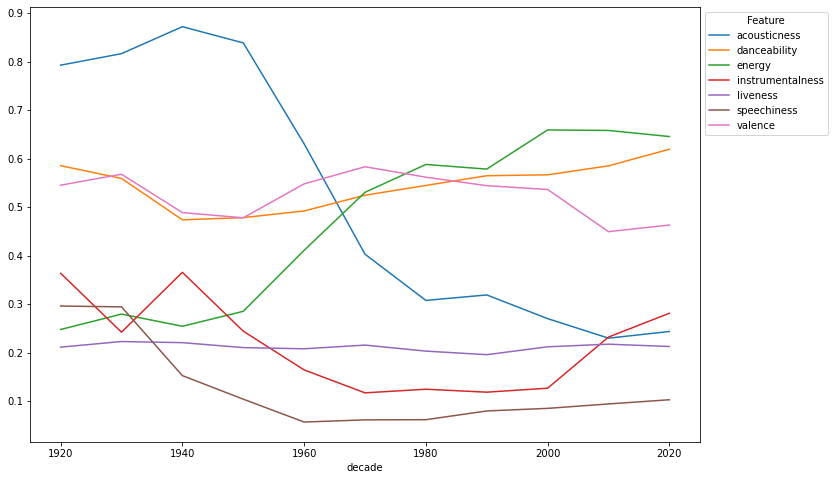

In [6]:
trends = avgs.drop(["duration_ms","explicit","key","mode","year","tempo","popularity","loudness"],axis=1)
trends.plot(figsize=(12,8)).legend(title='Feature', bbox_to_anchor=(1, 1));

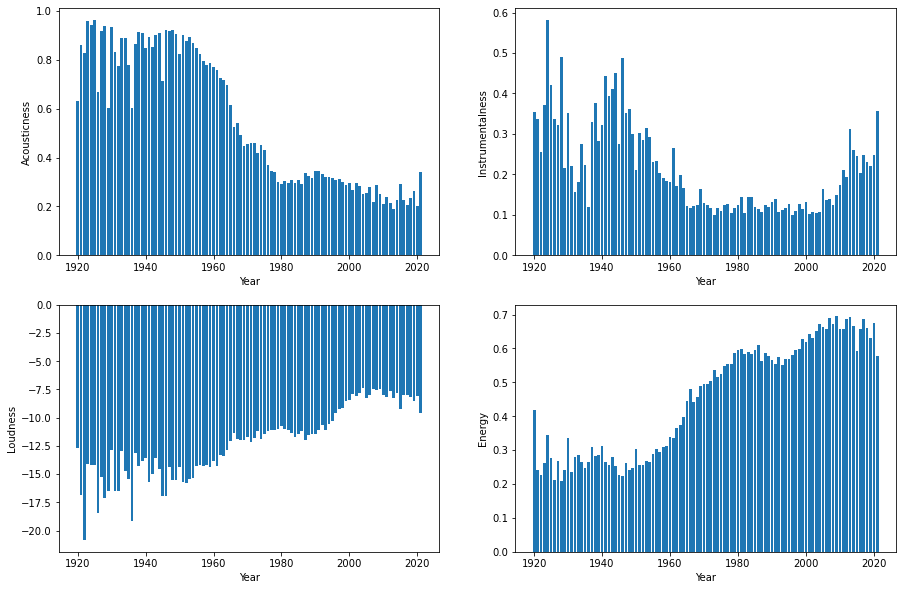

In [7]:
avgs2 = data.groupby('year').mean()
avgs2['year'] = avgs2.index
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0, 0].bar(avgs2['year'], avgs2['acousticness'])
axs[0, 0].set_ylabel("Acousticness")
axs[0, 0].set_xlabel("Year")
axs[0, 1].bar(avgs2['year'], avgs2['instrumentalness'])
axs[0, 1].set_ylabel("Instrumentalness")
axs[0, 1].set_xlabel("Year")
axs[1, 0].bar(avgs2['year'], avgs2['loudness'])
axs[1, 0].set_ylabel("Loudness")
axs[1, 0].set_xlabel("Year")
axs[1, 1].bar(avgs2['year'], avgs2['energy'])
axs[1, 1].set_ylabel("Energy")
axs[1, 1].set_xlabel("Year");

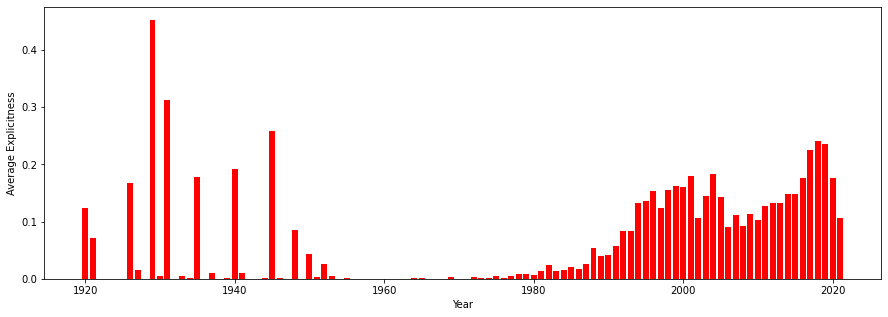

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(15,5))
axs.bar(avgs2['year'], avgs2['explicit'], color='red')
axs.set_ylabel("Average Explicitness")
axs.set_xlabel("Year");

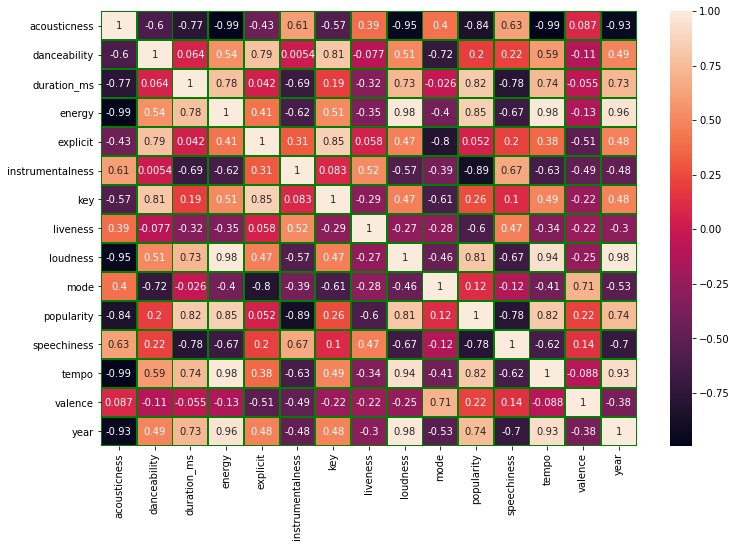

In [9]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(avgs.corr(), linewidths= 0.75, linecolor='green', annot=True);

### Model Training & Testing

#### Random Forest

In [10]:
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("ProjectSpark") \
        .getOrCreate()

In [11]:
schema = StructType([
    StructField("acousticness", FloatType()),
    # StructField("artists", StringType()),
    StructField("danceability", FloatType()),
    StructField("duration_ms", IntegerType()),
    StructField("energy", FloatType()),
    StructField("explicit", IntegerType()),
    StructField("id", StringType()),
    StructField("instrumentalness", FloatType()),
    StructField("key", IntegerType()),
    StructField("liveness", FloatType()),
    StructField("loudness", FloatType()),
    StructField("mode", IntegerType()),
    # StructField("name", StringType()),
    StructField("popularity", IntegerType()),
    # StructField("release_date", StringType()),
    StructField("speechiness", FloatType()),
    StructField("tempo", FloatType()),
    StructField("valence", FloatType()),
    StructField("year", IntegerType()),
    StructField("decade", IntegerType())
])

In [12]:
modelDf = spark.read.format("csv").option("header", "true").schema(schema).load("withDecade.csv")
modelDf.printSchema()

root
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: float (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- decade: integer (nullable = true)



In [13]:
## Split Data into Training & Test Sets
(trainSet, testSet) = modelDf.randomSplit([0.75, 0.25], seed=314)
trainSet.head()

Row(acousticness=0.0, danceability=0.0, duration_ms=5991, energy=0.0, explicit=0, id='3IcXTeq9O2dpsSXsDj9naH', instrumentalness=0.0, key=0, liveness=0.0, loudness=-60.0, mode=0, popularity=0, speechiness=0.0, tempo=0.0, valence=0.0, year=1938, decade=1930)

In [14]:
## Define RF Pipeline Step 1
labIndex = StringIndexer(inputCol="decade", outputCol="decadeIndex").setHandleInvalid("skip").fit(modelDf)
## RF Pipeline Step 2
featureVecs = VectorAssembler(inputCols=["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", 
                                        "speechiness", "tempo", "valence"], outputCol="features")
## RF Pipeline Step 3
randomBoi = RandomForestClassifier(labelCol="decadeIndex", featuresCol="features", numTrees=10)
## RF Pipeline Step 4
reLabel = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labIndex.labels)

In [15]:
## Define RF Pipeline Stages
randoPipe = Pipeline(stages=[labIndex, featureVecs, randomBoi, reLabel])

In [16]:
## Define evaluation metric
eval = MulticlassClassificationEvaluator(labelCol="decadeIndex", predictionCol="prediction", metricName="accuracy")

In [17]:
## Define Parameter grid
paramGrid = (ParamGridBuilder()\
             .addGrid(randomBoi.maxDepth, [2, 5, 10])\
             .addGrid(randomBoi.maxBins, [5, 10, 20])\
             .addGrid(randomBoi.numTrees, [5, 20, 50])\
             .build())

crossval = CrossValidator(
    estimator=randoPipe,
    estimatorParamMaps=paramGrid,
    evaluator=eval,
    numFolds=5)

randomModel = crossval.fit(trainSet)

#### RF Predictions & Testing

In [81]:
preds = randomModel.transform(testSet)

In [82]:
accRF = eval.evaluate(preds)
print("Test Error = %g" % (1.0 - accRF))

Test Error = 0.629854


In [20]:
print(randomModel.bestModel.stages[2])

RandomForestClassificationModel: uid=RandomForestClassifier_e43d5d0504b4, numTrees=50, numClasses=11, numFeatures=9


#### Decision Tree

In [21]:
from pyspark.ml.classification import DecisionTreeClassifier

In [22]:
## Define DT Pipeline Step 1
labIndex = StringIndexer(inputCol="decade", outputCol="decadeIndex").setHandleInvalid("skip").fit(modelDf)
## Define DT Pipeline Step 2
assembler = VectorAssembler(inputCols=["acousticness", "danceability", "energy", "explicit", "instrumentalness", 
                                       "key", "liveness", "loudness", "mode",
                                       "speechiness", "tempo", "valence"], outputCol="features")
## Define DT Pipeline Step 3
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=12)
## Define DT Pipeline Step 4
dt = DecisionTreeClassifier(labelCol="decadeIndex", featuresCol="indexedFeatures")
## Define DT Pipeline Step 5
reLabel = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labIndex.labels)

In [23]:
## Define DT Pipeline Stages
pipeDT = Pipeline(stages=[labIndex, assembler, featureIndexer, dt, reLabel])

In [24]:
pgDT = (ParamGridBuilder()\
             .addGrid(randomBoi.maxDepth, [5, 10, 20, 100])\
             .addGrid(randomBoi.maxBins, [5, 10, 20, 100])\
             .build())

cvDT = CrossValidator(
    estimator=pipeDT,
    estimatorParamMaps=pgDT,
    evaluator=eval,
    numFolds=10)

dtmod = cvDT.fit(trainSet)

#### DT Predictions and Testing

In [25]:
preds = dtmod.transform(testSet)

In [26]:
accDT = eval.evaluate(preds)
print("Test Error = %g " % (1.0 - accDT))

Test Error = 0.705936 


#### OneVsRest utilizing Logistic Regression

In [27]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.feature import MaxAbsScaler

In [28]:
## Define OvR Pipeline Steps
## Step 1
labIndex = StringIndexer(inputCol="decade", outputCol="decadeIndex").setHandleInvalid("skip").fit(modelDf)
## Step 2
featVec = VectorAssembler(inputCols=["acousticness", "danceability", "energy", "instrumentalness", 
                                       "liveness", "loudness", "explicit", "mode", "key",
                                       "speechiness", "tempo", "valence"],outputCol="features")
## Step 3
## Scale Features
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
## Step 4
## Instantiate base classifier
lr = LogisticRegression(maxIter=1000, tol=1e-6, fitIntercept=True)
## Instatiate One Vs Rest Classifier
ovr = OneVsRest(classifier=lr,featuresCol='scaledFeatures',labelCol='decadeIndex',predictionCol="newPrediction")
## Step 5
reLabel = IndexToString(inputCol="newPrediction",outputCol="predictedLabel",labels=labIndex.labels)

In [29]:
## Define OvR Pipeline Stages
pipOvR = Pipeline(stages=[labIndex, featVec, scaler, ovr, reLabel])

In [30]:
## Define Evaluation Metric
eva1vr=MulticlassClassificationEvaluator(labelCol="decadeIndex",predictionCol="newPrediction",metricName="accuracy")

In [31]:
pg1vr = (ParamGridBuilder()\
             .addGrid(lr.maxIter, [10, 100, 1000])\
             .addGrid(lr.elasticNetParam, [0, 0.1, 1])\
             .build())

cv1vr = CrossValidator(
    estimator=pipOvR,
    estimatorParamMaps=pg1vr,
    evaluator=eva1vr,
    numFolds=5)

OvRmod = cv1vr.fit(trainSet)

#### OneVsRest Predictions and Testing

In [32]:
OvrPreds = OvRmod.transform(testSet)
acc1vr = eva1vr.evaluate(OvrPreds)
print("Test Error = %g " % (1.0 - acc1vr))

Test Error = 0.693229 


In [33]:
coeffs = []
for x in range(0,11):
    coeffs.append(OvRmod.bestModel.stages[3].models[x].coefficients)

for i,p in enumerate(coeffs):
    print('Log Model {} Coefficients: {}'.format(i+1, p))

Log Model 1 Coefficients: [-1.2154560750546048,2.8514309009980914,0.00990286463979539,1.0839395665452563,0.2842245144594308,9.096713105281587,0.6789707644783467,-0.11207369220318475,0.03414882538531857,-0.6510667827309735,1.1548032094188532,-2.9127878269922207]
Log Model 2 Coefficients: [-1.3846019866976769,0.5394742618024523,0.3849566547679685,-0.8401650955296365,-0.484998042915969,-1.9076530587497404,0.5758470462022712,0.19411439810428466,0.12910991846617864,-2.150135636500643,-0.16194397237438432,-0.2609280505959264]
Log Model 3 Coefficients: [-1.2575623177890634,-1.4707228836959794,0.21091701601841384,-1.2153617424523149,0.20931087437974336,-4.626807329917335,-2.9018275515438012,0.12914567764653076,-0.13049095926444584,-2.6260481533308235,-0.1637579292451052,1.4000085157166693]
Log Model 4 Coefficients: [-1.6634273991509831,0.4103601794171847,2.604186241716652,-1.4165780960894616,-0.2894266242399698,-10.810710719679047,-1.0002289713519785,0.0558807416478453,0.04228136260888012,-3.9

#### Multinomial Logistic Regression

In [56]:
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel
from pyspark.ml.feature import StandardScaler

In [57]:
modelDf = modelDf.withColumn("explicit", modelDf["explicit"].cast(StringType()))
modelDf = modelDf.withColumn("mode", modelDf["mode"].cast(StringType()))
# modelDf.printSchema()

In [58]:
categoricalColumns = ['explicit','mode']
stages = []
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

    
labelIndexer = StringIndexer(inputCol = 'decade', outputCol = 'label')

In [59]:
stages += [labelIndexer]

numericCols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="unscaled_features")
stages += [assembler]


#standardize and scale features to mean 0 and variance 1
standardScaler = StandardScaler(inputCol="unscaled_features",
                                outputCol="features",
                                withMean=True,
                                withStd=True)
stages += [standardScaler]

In [60]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(modelDf)
dff2 = pipelineModel.transform(modelDf)

In [61]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

In [62]:
(training, test) = dff2.randomSplit([0.75, 0.25], seed=314)

In [63]:
lrModel = lr.fit(training)

#Row(acousticness=0.0, danceability=0.0, duration_ms=5108, energy=0.0, explicit=0, id='0hr9kRUi2X4MXc72A4VxG4', instrumentalness=0.0, key=0, liveness=0.0, loudness=-60.0, mode=0, popularity=0, speechiness=0.0, tempo=0.0, valence=0.0, year=1949, decade=1940)

In [65]:
predictions = lrModel.transform(test)

#### MLR Predictions and Testing

In [71]:
evamlr=MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
accMLR = evamlr.evaluate(predictions)
print("Test Error = %g " % (1.0 - accMLR))

Test Error = 0.689488 


In [72]:
predictions.select( 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  9.0|[3.70021927409786...|       0.0|[0.47556504828061...|
|  1.0|[1.34874657323978...|       3.0|[0.07676325526366...|
|  7.0|[1.67774021844005...|       0.0|[0.20980838718027...|
|  2.0|[2.55749610407808...|       0.0|[0.36012436572898...|
|  1.0|[2.93861878417222...|       0.0|[0.25627527095404...|
|  7.0|[1.88043681458655...|       0.0|[0.21869461611173...|
|  1.0|[4.95290279108750...|       0.0|[0.62974440863166...|
|  3.0|[3.07569821655385...|       0.0|[0.35193717701655...|
|  3.0|[1.78413127269503...|       3.0|[0.11407998633652...|
|  1.0|[1.29420304887753...|       3.0|[0.07201786426625...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [73]:
trainingSummary = lrModel.summary

In [74]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

Coefficients: 
DenseMatrix([[-0.3077287 , -0.03751048, -0.73364708,  0.58104708,  0.28040234,
               0.33289548,  0.0140544 ,  0.77792116, -0.20508892,  0.16830547,
              -0.99830852],
             [-0.2846381 ,  0.07722676, -0.83589011,  0.13914884,  0.32764538,
              -0.2175576 , -0.07626181, -0.31480882, -0.440008  ,  0.01700929,
              -0.27899657],
             [ 0.6162916 ,  0.07307863, -0.77836532, -0.30497644,  0.26944725,
              -0.40753872,  0.01206904, -0.6515686 , -0.43103269, -0.02880073,
               0.25010286],
             [ 0.03655687,  0.03852344, -0.98712685,  0.04748871,  0.82183192,
              -0.43392489, -0.0702164 , -1.07500156, -0.63531078,  0.05134452,
              -0.18910454],
             [ 0.26144311, -0.05117319,  1.17203889, -0.43960718, -0.40787617,
              -0.15558862,  0.01031375, -0.03788758,  0.39101144, -0.07389382,
               0.45832111],
             [ 0.5663251 ,  0.04604288, -0.07838694, -0

In [69]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.3101834475891387
FPR: 0.08725348286143127
TPR: 0.3101834475891387
F-measure: 0.28166672791621117
Precision: 0.2937483189547036
Recall: 0.3101834475891387


#### Naive Bayes

In [75]:
from pyspark.ml.feature import Bucketizer
from pyspark.ml.classification import NaiveBayes

In [76]:
## Define Naive Bayes Pipeline Step 1
labIndex = StringIndexer(inputCol="decade", outputCol="decadeIndex").setHandleInvalid("skip").fit(modelDf)

## Define Naive Bayes Pipeline Step 2
splits_loud = [-float("inf"), 0.3, 0.65, float("inf")]
bucketizer_loud = Bucketizer(splits=splits_loud, inputCol="loudness", outputCol="bucketedloudness").setHandleInvalid("skip")

## Define Naive Bayes Pipeline Step 3
splits_acou = [-float("inf"), 0.3, 0.65, float("inf")]
bucketizer_acou = Bucketizer(splits=splits_acou, inputCol="acousticness", outputCol="bucketedacousticness").setHandleInvalid("skip")

## Define Naive Bayes Pipeline Step 4
featureVecs = VectorAssembler(inputCols=["bucketedacousticness", "danceability", "energy", "instrumentalness", "liveness", "bucketedloudness", 
                                         "speechiness", "tempo", "valence"], outputCol="features")

## Define Naive Bayes Pipeline Step 5
nb = NaiveBayes(featuresCol='features', labelCol='decadeIndex', smoothing=1.0, modelType="multinomial")

## Define Naive Bayes Pipeline Step 6
reLabel = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labIndex.labels)

In [77]:
## Define Naive Bayes Pipeline Stages
nbPipe = Pipeline(stages=[labIndex, bucketizer_loud, bucketizer_acou, featureVecs, nb, reLabel])

In [78]:
nbModel = nbPipe.fit(trainSet)

#### Naive Bayes Prediction & Testing

In [83]:
preds = nbModel.transform(testSet)

In [84]:
accNB = eval.evaluate(preds)
print("Test Error = %g" % (1.0 - accNB))

Test Error = 0.767509


### Test Accuracy of Models

In [91]:
testAcc = spark.createDataFrame(
    [
        ("Random Forest", accRF),
        ("Decision Tree", accDT),
        ("One vs Rest Logistic Regression", acc1vr),
        ("Multinomial Logistic Regression", accMLR),
        ("Naive Bayes", accNB)
    ],
    ['Model', 'Test Accuracy']
)

testAcc.show(truncate=False)

+-------------------------------+-------------------+
|Model                          |Test Accuracy      |
+-------------------------------+-------------------+
|Random Forest                  |0.37014646165077336|
|Decision Tree                  |0.29406396860884243|
|One vs Rest Logistic Regression|0.3067709996806132 |
|Multinomial Logistic Regression|0.3105123876442944 |
|Naive Bayes                    |0.23249076059679702|
+-------------------------------+-------------------+

